This tutorial is an adaptation and expansion of the one provided on https://scikit-image.org/docs/stable/user_guide/tutorial_segmentation.html

In [1]:
%pip install scipy

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import matplotlib.pyplot as plt 
import skimage as ski 
import numpy as np
import scipy as sp

For this tutorial, we will consider an image showing several coins

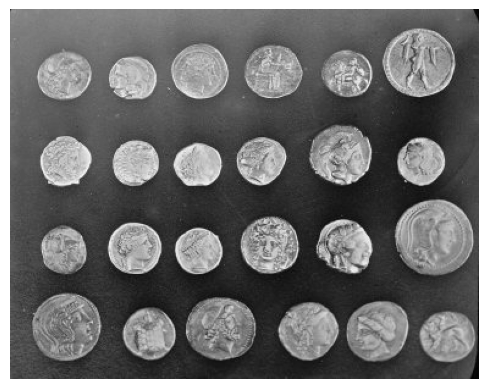

In [3]:
coins = ski.data.coins()
plt.imshow(coins, cmap='gray')
plt.axis('off')
plt.show(block=False)

If you check the histograms of the gray values, there is not a clear split in the values of the pixels, conversely to the "camera" picture seen in the previous example

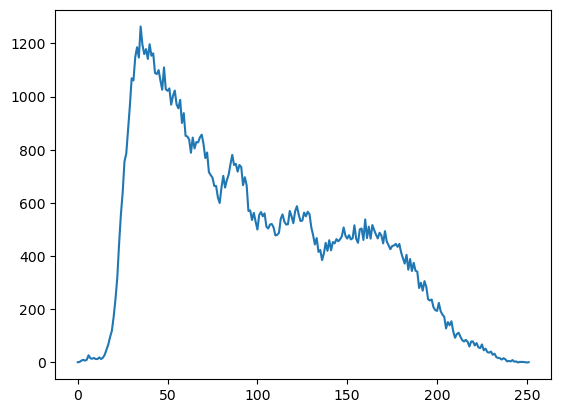

In [4]:
hist, hist_centers = ski.exposure.histogram(coins)
plt.plot(hist)
plt.show(block=False)

Let's still stubbornly try to apply global and local thresholding and see whan happens

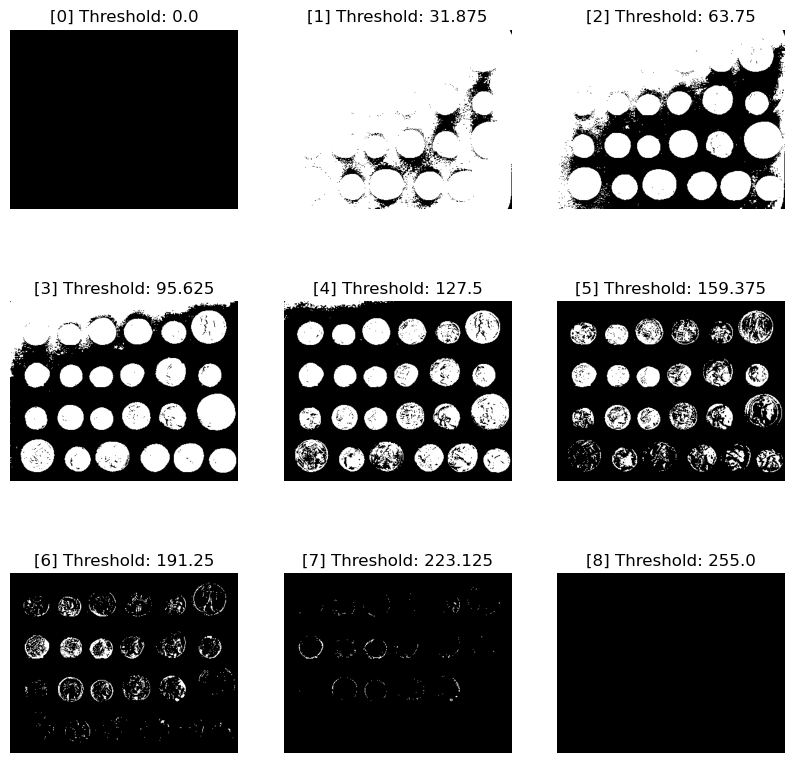

In [5]:
n_thresholds = 9
thresholds = np.linspace(
    0,
    255,
    n_thresholds
)
fig, axes = plt.subplots(
    int(np.sqrt(n_thresholds)),
    int(np.sqrt(n_thresholds)),
    figsize=(10, 10),
)
axes = axes.reshape(-1)
for idx, t in enumerate(thresholds):
    masked = coins > t
    axes[idx].imshow(masked, cmap='gray')
    axes[idx].set_title(f"[{idx}] Threshold: {t}")
    axes[idx].axis('off')

plt.show(block=False)

Would local thresholding do better?

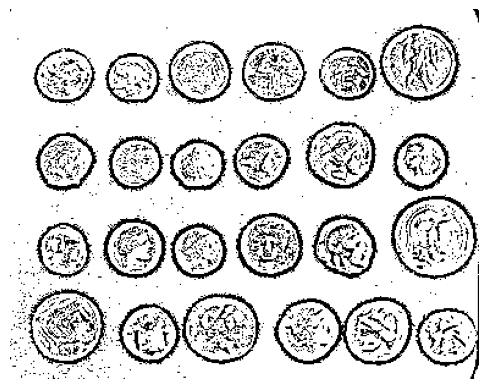

In [6]:
block_size = 15
local_thresh = ski.filters.threshold_local(coins, block_size, offset=10)
binary_local = coins > local_thresh
plt.imshow(binary_local, cmap='gray')
plt.axis('off')
plt.show(block=False)

Now that we have demonstrated we cannot use thresholds, let's start by trying to detect the edges with the Canny detector

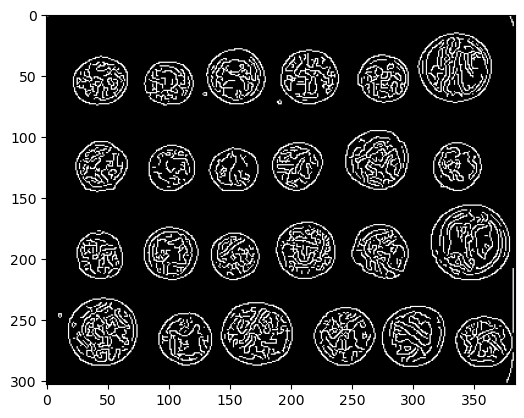

In [7]:
edges = ski.feature.canny(coins / 255.)
plt.imshow(edges, cmap='gray')
plt.show(block=False)

Now, we can fill them to mask the coins

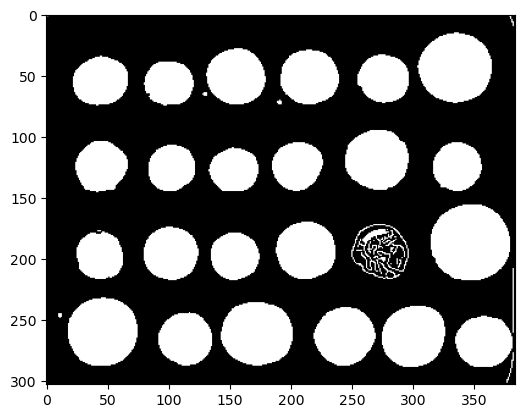

In [8]:
filled = sp.ndimage.binary_fill_holes(edges)
plt.imshow(filled, cmap='gray')
plt.show(block=False)

And we can remove objects smaller than a certain area 

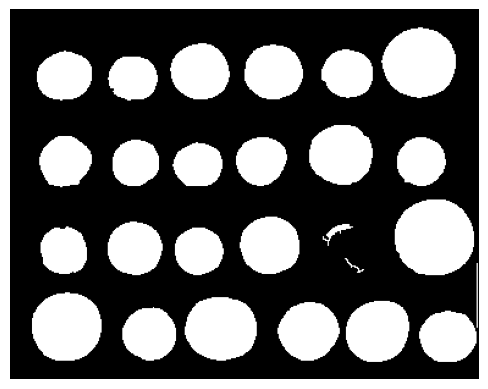

In [9]:
label_objects, nb_labels = sp.ndimage.label(filled)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0
coins_mask = mask_sizes[label_objects]
plt.imshow(coins_mask, cmap='gray')
plt.axis('off')
plt.show(block=False)

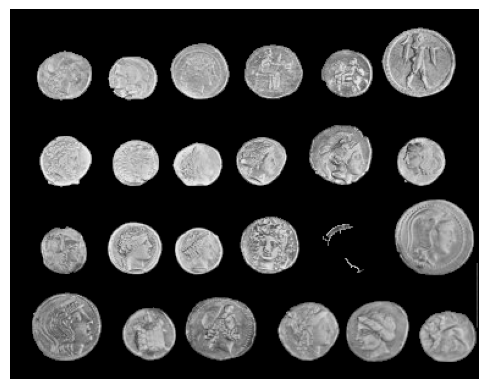

In [10]:
recognised_coins = np.where(coins_mask > 0, coins, 0)
plt.imshow(recognised_coins, cmap='gray')
plt.axis('off')
plt.show(block=False)

As we can see, one of the coin was lost because its countour was not "closed" properly. Region-based segmentation is more robust in this regard.

First, let's recall the histogram of gray values.

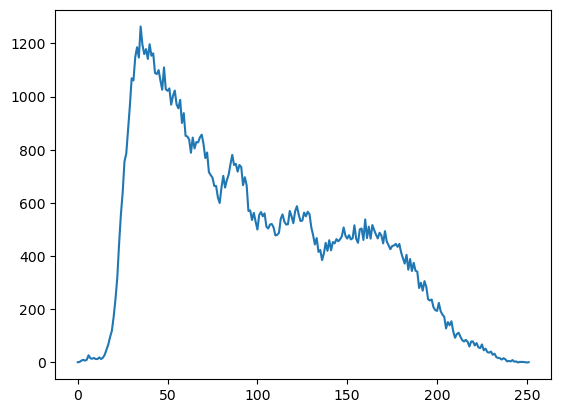

In [11]:
hist, hist_centers = ski.exposure.histogram(coins)
plt.plot(hist)
plt.show(block=False)

We can be fairly sure that two extremes of this distribution are not coins:

<30 and >150

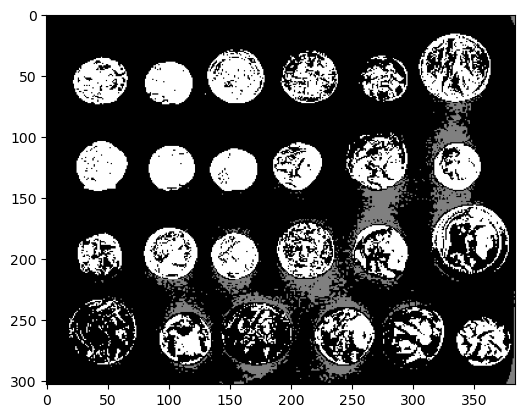

In [ ]:
markers = np.where(coins < 30, 1, 0) + np.where(coins > 150, 2, 0)
plt.imshow(markers, cmap='gray')
plt.axis('off')
plt.show(block=False)

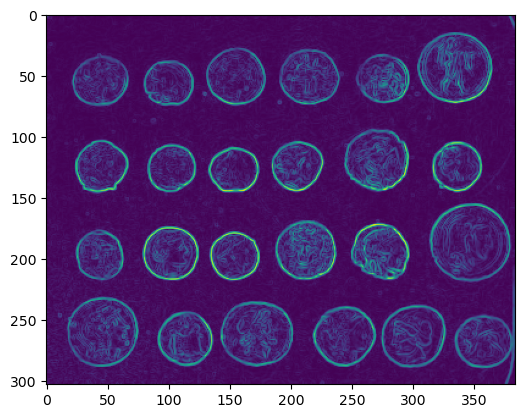

In [ ]:
elevation_map = ski.filters.sobel(coins)
plt.imshow(elevation_map)
plt.axis('off')
plt.show(block=False)

In [14]:
np.shape(elevation_map)

(303, 384)

In [15]:
%matplotlib qt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# Create X and Y coordinates that match Z
plt.ion()
nx, ny = elevation_map.shape
x = np.arange(ny)  
y = np.arange(nx)
X, Y = np.meshgrid(x, y) 
ax.plot_surface(
    X,
    Y,
    elevation_map,
    cmap='terrain'
)
# let's see the image more from above
ax.view_init(elev=75, azim=-75)
plt.show(block=True)

plt.ioff()
%matplotlib inline
import matplotlib.pyplot as plt

Now we will apply the "watershed segmentation" algorithm. As the name suggests, it simulates water flowing on the image, flooding the background and leaving the markers that are "high enough", depending on the elevation profile. 

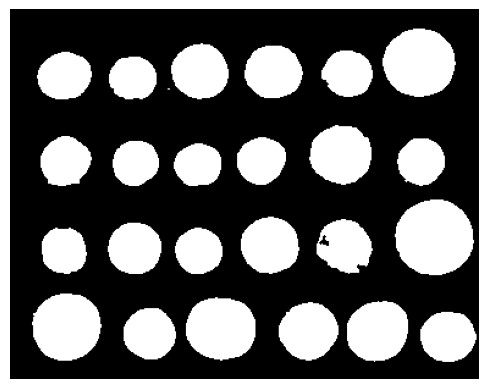

In [16]:
water_seg = ski.segmentation.watershed(elevation_map, markers)
plt.imshow(water_seg, cmap='gray')
plt.axis('off')
plt.show(block=False)

Let's fille the small holes that are there

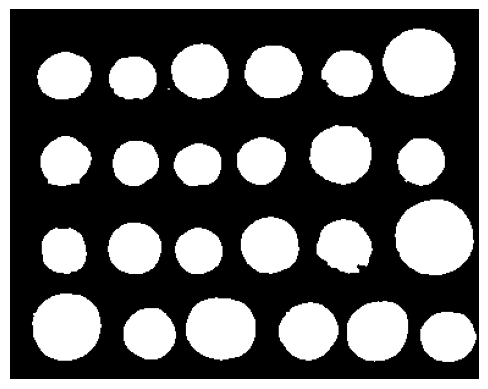

In [17]:
water_seg = sp.ndimage.binary_fill_holes(water_seg - 1)
plt.imshow(water_seg, cmap='gray')
plt.axis('off')
plt.show(block=False)

Previous segmentation:


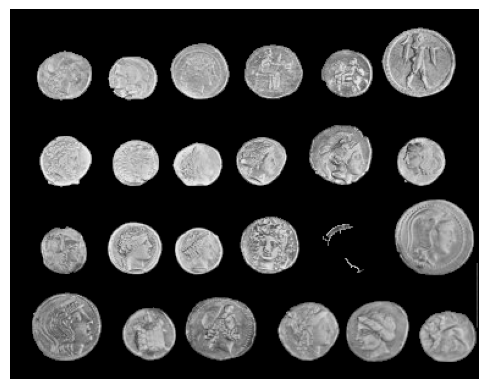

Watershed segmentation:


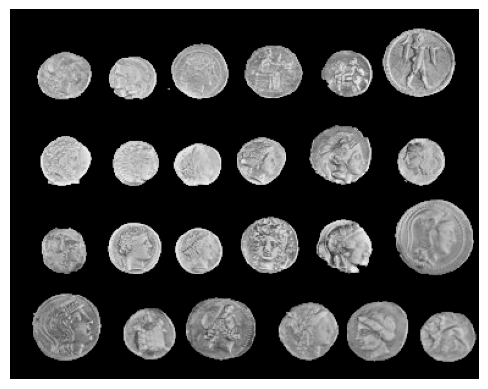

Difference: 


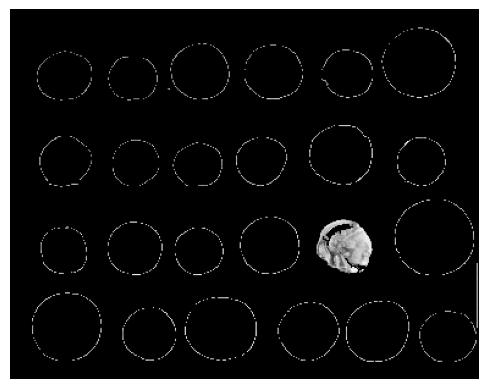

In [ ]:
print('Previous segmentation:')
plt.imshow(recognised_coins, cmap='gray')
plt.axis('off')
plt.show(block=False)

print('Watershed segmentation:')
# NOTE: if you don't use sp.ndimage.binary_fill_holes to overwrite water_seg in the previous cell, the coins are marked as 2, not 1!
recognised_coins_ws = np.where(water_seg == 1, coins, 0)
plt.imshow(recognised_coins_ws, cmap='gray')
plt.axis('off')
plt.show(block=False)

print('Difference: ')
diff_rec = recognised_coins_ws - recognised_coins
plt.imshow(diff_rec, cmap='gray')
plt.axis('off')
plt.show(block=False)

Finally, we can label the coins and obtain our segments

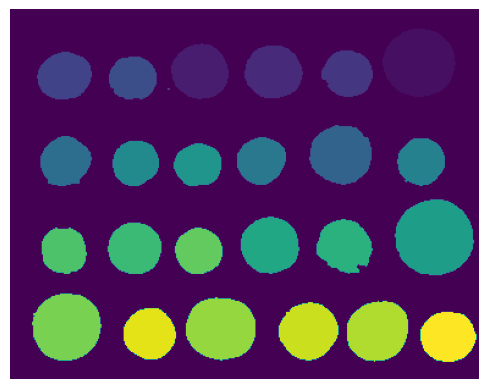

In [24]:
labelled_coins, _ = sp.ndimage.label(water_seg)
plt.imshow(labelled_coins, cmap=None)
plt.axis('off')
plt.show(block=False)

In [34]:
np.unique(labelled_coins)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25], dtype=int32)

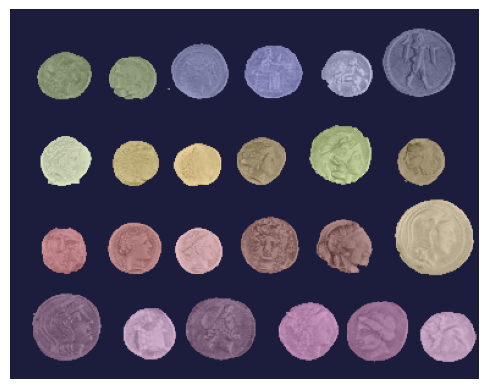

In [37]:
alpha = 0.5  # blending factor
I_rgb = np.stack([recognised_coins_ws, recognised_coins_ws, recognised_coins_ws], axis=-1)
num_labels = labelled_coins.max() + 1   # = 26
cmap = plt.cm.tab20b
C = (cmap(np.linspace(0, 1, num_labels))[:, :3] * 255).astype(np.uint8)

overlay = (1 - alpha) * I_rgb + alpha * C[labelled_coins]
overlay = overlay.astype(np.uint8)
plt.imshow(overlay)
plt.axis('off')
plt.show(block=False)